# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 1ms/sample - loss: 243.3595 - y1_output_loss: 120.2986 - y2_output_loss: 120.8200 - y1_output_root_mean_squared_error: 11.0196 - y2_output_root_mean_squared_error: 11.0421 - val_loss: 31.1721 - val_y1_output_loss: 14.3335 - val_y2_output_loss: 16.1979 - val_y1_output_root_mean_squared_error: 3.8221 - val_y2_output_root_mean_squared_error: 4.0698
Epoch 2/500
614/614 [==============================] - 0s 152us/sample - loss: 30.8378 - y1_output_loss: 11.7495 - y2_output_loss: 19.4982 - y1_output_root_mean_squared_error: 3.4335 - y2_output_root_mean_squared_error: 4.3645 - val_loss: 26.4021 - val_y1_output_loss: 10.7236 - val_y2_output_loss: 15.2715 - val_y1_output_root_mean_squared_error: 3.2834 - val_y2_output_root_mean_squared_error: 3.9524
Epoch 3/500
614/614 [==============================] - 0s 155us/sample - loss: 27.2729 - y1_output_loss: 10.6754 - y2_output_loss: 16.5320 - y1_o

614/614 [==============================] - 0s 146us/sample - loss: 19.3857 - y1_output_loss: 6.8891 - y2_output_loss: 12.3378 - y1_output_root_mean_squared_error: 2.6360 - y2_output_root_mean_squared_error: 3.5267 - val_loss: 13.2359 - val_y1_output_loss: 5.4912 - val_y2_output_loss: 7.3624 - val_y1_output_root_mean_squared_error: 2.3746 - val_y2_output_root_mean_squared_error: 2.7563
Epoch 22/500
614/614 [==============================] - 0s 142us/sample - loss: 15.6106 - y1_output_loss: 6.0335 - y2_output_loss: 9.6570 - y1_output_root_mean_squared_error: 2.4529 - y2_output_root_mean_squared_error: 3.0974 - val_loss: 16.6962 - val_y1_output_loss: 8.2312 - val_y2_output_loss: 8.4406 - val_y1_output_root_mean_squared_error: 2.8415 - val_y2_output_root_mean_squared_error: 2.9364
Epoch 23/500
614/614 [==============================] - 0s 148us/sample - loss: 15.4138 - y1_output_loss: 5.9883 - y2_output_loss: 9.6185 - y1_output_root_mean_squared_error: 2.4111 - y2_output_root_mean_squared_

614/614 [==============================] - 0s 148us/sample - loss: 7.6699 - y1_output_loss: 2.6819 - y2_output_loss: 5.0342 - y1_output_root_mean_squared_error: 1.6213 - y2_output_root_mean_squared_error: 2.2453 - val_loss: 6.9148 - val_y1_output_loss: 3.1868 - val_y2_output_loss: 3.8344 - val_y1_output_root_mean_squared_error: 1.7696 - val_y2_output_root_mean_squared_error: 1.9450
Epoch 42/500
614/614 [==============================] - 0s 140us/sample - loss: 7.5119 - y1_output_loss: 2.6334 - y2_output_loss: 4.9064 - y1_output_root_mean_squared_error: 1.6197 - y2_output_root_mean_squared_error: 2.2110 - val_loss: 28.9945 - val_y1_output_loss: 9.6709 - val_y2_output_loss: 19.4787 - val_y1_output_root_mean_squared_error: 3.0691 - val_y2_output_root_mean_squared_error: 4.4244
Epoch 43/500
614/614 [==============================] - 0s 146us/sample - loss: 9.1096 - y1_output_loss: 3.0690 - y2_output_loss: 6.1372 - y1_output_root_mean_squared_error: 1.7382 - y2_output_root_mean_squared_erro

Epoch 62/500
614/614 [==============================] - 0s 173us/sample - loss: 4.6696 - y1_output_loss: 1.2819 - y2_output_loss: 3.3472 - y1_output_root_mean_squared_error: 1.1375 - y2_output_root_mean_squared_error: 1.8373 - val_loss: 4.5837 - val_y1_output_loss: 1.4852 - val_y2_output_loss: 2.9707 - val_y1_output_root_mean_squared_error: 1.2315 - val_y2_output_root_mean_squared_error: 1.7513
Epoch 63/500
614/614 [==============================] - 0s 155us/sample - loss: 4.7862 - y1_output_loss: 1.2982 - y2_output_loss: 3.4540 - y1_output_root_mean_squared_error: 1.1427 - y2_output_root_mean_squared_error: 1.8656 - val_loss: 6.1657 - val_y1_output_loss: 1.2676 - val_y2_output_loss: 4.7115 - val_y1_output_root_mean_squared_error: 1.1330 - val_y2_output_root_mean_squared_error: 2.2095
Epoch 64/500
614/614 [==============================] - 0s 144us/sample - loss: 4.7905 - y1_output_loss: 1.3843 - y2_output_loss: 3.3719 - y1_output_root_mean_squared_error: 1.1788 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 145us/sample - loss: 3.0489 - y1_output_loss: 0.9133 - y2_output_loss: 2.3106 - y1_output_root_mean_squared_error: 0.9126 - y2_output_root_mean_squared_error: 1.4886 - val_loss: 24.7717 - val_y1_output_loss: 7.5501 - val_y2_output_loss: 18.8422 - val_y1_output_root_mean_squared_error: 2.6868 - val_y2_output_root_mean_squared_error: 4.1896
Epoch 84/500
614/614 [==============================] - 0s 163us/sample - loss: 3.5660 - y1_output_loss: 0.8788 - y2_output_loss: 2.6928 - y1_output_root_mean_squared_error: 0.9408 - y2_output_root_mean_squared_error: 1.6374 - val_loss: 5.8998 - val_y1_output_loss: 0.7202 - val_y2_output_loss: 5.0097 - val_y1_output_root_mean_squared_error: 0.8635 - val_y2_output_root_mean_squared_error: 2.2703
Epoch 85/500
614/614 [==============================] - 0s 152us/sample - loss: 2.7496 - y1_output_loss: 0.6658 - y2_output_loss: 2.0722 - y1_output_root_mean_squared_error: 0.8166 - y2_output_root_mean

Epoch 104/500
614/614 [==============================] - 0s 151us/sample - loss: 2.5104 - y1_output_loss: 0.6444 - y2_output_loss: 1.8791 - y1_output_root_mean_squared_error: 0.8000 - y2_output_root_mean_squared_error: 1.3676 - val_loss: 4.5800 - val_y1_output_loss: 0.8656 - val_y2_output_loss: 3.9640 - val_y1_output_root_mean_squared_error: 0.9455 - val_y2_output_root_mean_squared_error: 1.9199
Epoch 105/500
614/614 [==============================] - 0s 151us/sample - loss: 2.4966 - y1_output_loss: 0.6033 - y2_output_loss: 1.8996 - y1_output_root_mean_squared_error: 0.7801 - y2_output_root_mean_squared_error: 1.3741 - val_loss: 4.9842 - val_y1_output_loss: 0.6142 - val_y2_output_loss: 4.2812 - val_y1_output_root_mean_squared_error: 0.7938 - val_y2_output_root_mean_squared_error: 2.0866
Epoch 106/500
614/614 [==============================] - 0s 150us/sample - loss: 2.6174 - y1_output_loss: 0.5936 - y2_output_loss: 2.0024 - y1_output_root_mean_squared_error: 0.7728 - y2_output_root_mea

614/614 [==============================] - 0s 160us/sample - loss: 2.4306 - y1_output_loss: 0.5428 - y2_output_loss: 2.0274 - y1_output_root_mean_squared_error: 0.7377 - y2_output_root_mean_squared_error: 1.3735 - val_loss: 41.3620 - val_y1_output_loss: 6.8195 - val_y2_output_loss: 37.7933 - val_y1_output_root_mean_squared_error: 2.5215 - val_y2_output_root_mean_squared_error: 5.9164
Epoch 125/500
614/614 [==============================] - 0s 161us/sample - loss: 3.3669 - y1_output_loss: 0.8635 - y2_output_loss: 2.4735 - y1_output_root_mean_squared_error: 0.9335 - y2_output_root_mean_squared_error: 1.5797 - val_loss: 2.7374 - val_y1_output_loss: 0.5471 - val_y2_output_loss: 2.1330 - val_y1_output_root_mean_squared_error: 0.7483 - val_y2_output_root_mean_squared_error: 1.4756
Epoch 126/500
614/614 [==============================] - 0s 157us/sample - loss: 2.8680 - y1_output_loss: 0.6590 - y2_output_loss: 2.2525 - y1_output_root_mean_squared_error: 0.8136 - y2_output_root_mean_squared_er

Epoch 145/500
614/614 [==============================] - 0s 159us/sample - loss: 1.8621 - y1_output_loss: 0.3898 - y2_output_loss: 1.4831 - y1_output_root_mean_squared_error: 0.6204 - y2_output_root_mean_squared_error: 1.2154 - val_loss: 2.2220 - val_y1_output_loss: 0.7467 - val_y2_output_loss: 1.5877 - val_y1_output_root_mean_squared_error: 0.8616 - val_y2_output_root_mean_squared_error: 1.2164
Epoch 146/500
614/614 [==============================] - 0s 151us/sample - loss: 1.7367 - y1_output_loss: 0.4012 - y2_output_loss: 1.3212 - y1_output_root_mean_squared_error: 0.6360 - y2_output_root_mean_squared_error: 1.1542 - val_loss: 1.8789 - val_y1_output_loss: 0.4633 - val_y2_output_loss: 1.4215 - val_y1_output_root_mean_squared_error: 0.6887 - val_y2_output_root_mean_squared_error: 1.1852
Epoch 147/500
614/614 [==============================] - 0s 155us/sample - loss: 1.6113 - y1_output_loss: 0.3951 - y2_output_loss: 1.2239 - y1_output_root_mean_squared_error: 0.6231 - y2_output_root_mea

614/614 [==============================] - 0s 152us/sample - loss: 1.4350 - y1_output_loss: 0.3222 - y2_output_loss: 1.1175 - y1_output_root_mean_squared_error: 0.5654 - y2_output_root_mean_squared_error: 1.0561 - val_loss: 3.2978 - val_y1_output_loss: 0.6610 - val_y2_output_loss: 2.6678 - val_y1_output_root_mean_squared_error: 0.7998 - val_y2_output_root_mean_squared_error: 1.6304
Epoch 166/500
614/614 [==============================] - 0s 159us/sample - loss: 1.6499 - y1_output_loss: 0.3806 - y2_output_loss: 1.2664 - y1_output_root_mean_squared_error: 0.6186 - y2_output_root_mean_squared_error: 1.1257 - val_loss: 1.6158 - val_y1_output_loss: 0.3661 - val_y2_output_loss: 1.3137 - val_y1_output_root_mean_squared_error: 0.6104 - val_y2_output_root_mean_squared_error: 1.1150
Epoch 167/500
614/614 [==============================] - 0s 151us/sample - loss: 1.4025 - y1_output_loss: 0.3379 - y2_output_loss: 1.0586 - y1_output_root_mean_squared_error: 0.5804 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 157us/sample - loss: 1.2278 - y1_output_loss: 0.2855 - y2_output_loss: 0.9563 - y1_output_root_mean_squared_error: 0.5284 - y2_output_root_mean_squared_error: 0.9740 - val_loss: 1.5517 - val_y1_output_loss: 0.3135 - val_y2_output_loss: 1.3143 - val_y1_output_root_mean_squared_error: 0.5588 - val_y2_output_root_mean_squared_error: 1.1133
Epoch 187/500
614/614 [==============================] - 0s 152us/sample - loss: 1.5811 - y1_output_loss: 0.2932 - y2_output_loss: 1.2870 - y1_output_root_mean_squared_error: 0.5431 - y2_output_root_mean_squared_error: 1.1341 - val_loss: 3.3270 - val_y1_output_loss: 0.3811 - val_y2_output_loss: 2.9521 - val_y1_output_root_mean_squared_error: 0.6121 - val_y2_output_root_mean_squared_error: 1.7182
Epoch 188/500
614/614 [==============================] - 0s 160us/sample - loss: 1.3208 - y1_output_loss: 0.2546 - y2_output_loss: 1.0649 - y1_output_root_mean_squared_error: 0.5053 - y2_output_root_mea

614/614 [==============================] - 0s 159us/sample - loss: 1.0137 - y1_output_loss: 0.2379 - y2_output_loss: 0.7742 - y1_output_root_mean_squared_error: 0.4868 - y2_output_root_mean_squared_error: 0.8813 - val_loss: 1.6988 - val_y1_output_loss: 0.3163 - val_y2_output_loss: 1.3794 - val_y1_output_root_mean_squared_error: 0.5633 - val_y2_output_root_mean_squared_error: 1.1754
Epoch 207/500
614/614 [==============================] - 0s 161us/sample - loss: 1.3636 - y1_output_loss: 0.3055 - y2_output_loss: 1.0485 - y1_output_root_mean_squared_error: 0.5534 - y2_output_root_mean_squared_error: 1.0283 - val_loss: 1.8468 - val_y1_output_loss: 0.2428 - val_y2_output_loss: 1.5836 - val_y1_output_root_mean_squared_error: 0.4980 - val_y2_output_root_mean_squared_error: 1.2644
Epoch 208/500
614/614 [==============================] - 0s 155us/sample - loss: 0.9203 - y1_output_loss: 0.2079 - y2_output_loss: 0.7098 - y1_output_root_mean_squared_error: 0.4573 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 157us/sample - loss: 0.9745 - y1_output_loss: 0.2438 - y2_output_loss: 0.7234 - y1_output_root_mean_squared_error: 0.4949 - y2_output_root_mean_squared_error: 0.8542 - val_loss: 1.3444 - val_y1_output_loss: 0.1997 - val_y2_output_loss: 1.2322 - val_y1_output_root_mean_squared_error: 0.4493 - val_y2_output_root_mean_squared_error: 1.0689
Epoch 228/500
614/614 [==============================] - 0s 155us/sample - loss: 1.1093 - y1_output_loss: 0.2643 - y2_output_loss: 0.8388 - y1_output_root_mean_squared_error: 0.5143 - y2_output_root_mean_squared_error: 0.9191 - val_loss: 1.6339 - val_y1_output_loss: 0.3809 - val_y2_output_loss: 1.2894 - val_y1_output_root_mean_squared_error: 0.6266 - val_y2_output_root_mean_squared_error: 1.1141
Epoch 229/500
614/614 [==============================] - 0s 159us/sample - loss: 0.9096 - y1_output_loss: 0.2395 - y2_output_loss: 0.6771 - y1_output_root_mean_squared_error: 0.4910 - y2_output_root_mea

614/614 [==============================] - 0s 162us/sample - loss: 0.8830 - y1_output_loss: 0.1976 - y2_output_loss: 0.7251 - y1_output_root_mean_squared_error: 0.4465 - y2_output_root_mean_squared_error: 0.8268 - val_loss: 3.5610 - val_y1_output_loss: 0.2537 - val_y2_output_loss: 3.5052 - val_y1_output_root_mean_squared_error: 0.5058 - val_y2_output_root_mean_squared_error: 1.8180
Epoch 248/500
614/614 [==============================] - 0s 160us/sample - loss: 0.7044 - y1_output_loss: 0.1744 - y2_output_loss: 0.5291 - y1_output_root_mean_squared_error: 0.4196 - y2_output_root_mean_squared_error: 0.7268 - val_loss: 1.6478 - val_y1_output_loss: 0.2688 - val_y2_output_loss: 1.4619 - val_y1_output_root_mean_squared_error: 0.5182 - val_y2_output_root_mean_squared_error: 1.1744
Epoch 249/500
614/614 [==============================] - 0s 152us/sample - loss: 0.8205 - y1_output_loss: 0.2032 - y2_output_loss: 0.6471 - y1_output_root_mean_squared_error: 0.4502 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 166us/sample - loss: 0.7358 - y1_output_loss: 0.1946 - y2_output_loss: 0.5408 - y1_output_root_mean_squared_error: 0.4390 - y2_output_root_mean_squared_error: 0.7369 - val_loss: 1.3362 - val_y1_output_loss: 0.3071 - val_y2_output_loss: 1.0499 - val_y1_output_root_mean_squared_error: 0.5572 - val_y2_output_root_mean_squared_error: 1.0128
Epoch 269/500
614/614 [==============================] - 0s 156us/sample - loss: 0.8620 - y1_output_loss: 0.2113 - y2_output_loss: 0.6474 - y1_output_root_mean_squared_error: 0.4616 - y2_output_root_mean_squared_error: 0.8055 - val_loss: 1.4098 - val_y1_output_loss: 0.2190 - val_y2_output_loss: 1.1820 - val_y1_output_root_mean_squared_error: 0.4679 - val_y2_output_root_mean_squared_error: 1.0913
Epoch 270/500
614/614 [==============================] - 0s 149us/sample - loss: 0.7552 - y1_output_loss: 0.1811 - y2_output_loss: 0.5685 - y1_output_root_mean_squared_error: 0.4264 - y2_output_root_mea

614/614 [==============================] - 0s 152us/sample - loss: 1.2605 - y1_output_loss: 0.2610 - y2_output_loss: 0.9922 - y1_output_root_mean_squared_error: 0.5098 - y2_output_root_mean_squared_error: 1.0003 - val_loss: 1.2620 - val_y1_output_loss: 0.2558 - val_y2_output_loss: 0.9908 - val_y1_output_root_mean_squared_error: 0.5068 - val_y2_output_root_mean_squared_error: 1.0026
Epoch 289/500
614/614 [==============================] - 0s 157us/sample - loss: 0.7432 - y1_output_loss: 0.2038 - y2_output_loss: 0.5333 - y1_output_root_mean_squared_error: 0.4529 - y2_output_root_mean_squared_error: 0.7335 - val_loss: 1.5237 - val_y1_output_loss: 0.3299 - val_y2_output_loss: 1.2709 - val_y1_output_root_mean_squared_error: 0.5703 - val_y2_output_root_mean_squared_error: 1.0947
Epoch 290/500
614/614 [==============================] - 0s 157us/sample - loss: 0.6111 - y1_output_loss: 0.1811 - y2_output_loss: 0.4308 - y1_output_root_mean_squared_error: 0.4251 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 151us/sample - loss: 0.7961 - y1_output_loss: 0.2050 - y2_output_loss: 0.5877 - y1_output_root_mean_squared_error: 0.4519 - y2_output_root_mean_squared_error: 0.7694 - val_loss: 1.4531 - val_y1_output_loss: 0.3504 - val_y2_output_loss: 1.0818 - val_y1_output_root_mean_squared_error: 0.5930 - val_y2_output_root_mean_squared_error: 1.0495
Epoch 310/500
614/614 [==============================] - 0s 154us/sample - loss: 0.6023 - y1_output_loss: 0.1599 - y2_output_loss: 0.4395 - y1_output_root_mean_squared_error: 0.4015 - y2_output_root_mean_squared_error: 0.6642 - val_loss: 1.0889 - val_y1_output_loss: 0.1840 - val_y2_output_loss: 0.8840 - val_y1_output_root_mean_squared_error: 0.4338 - val_y2_output_root_mean_squared_error: 0.9491
Epoch 311/500
614/614 [==============================] - 0s 150us/sample - loss: 0.6701 - y1_output_loss: 0.1638 - y2_output_loss: 0.5058 - y1_output_root_mean_squared_error: 0.4010 - y2_output_root_mea

614/614 [==============================] - 0s 159us/sample - loss: 0.6413 - y1_output_loss: 0.1844 - y2_output_loss: 0.4533 - y1_output_root_mean_squared_error: 0.4303 - y2_output_root_mean_squared_error: 0.6754 - val_loss: 1.0883 - val_y1_output_loss: 0.1927 - val_y2_output_loss: 0.9284 - val_y1_output_root_mean_squared_error: 0.4419 - val_y2_output_root_mean_squared_error: 0.9450
Epoch 330/500
614/614 [==============================] - 0s 157us/sample - loss: 0.4942 - y1_output_loss: 0.1579 - y2_output_loss: 0.3339 - y1_output_root_mean_squared_error: 0.3989 - y2_output_root_mean_squared_error: 0.5789 - val_loss: 0.9798 - val_y1_output_loss: 0.1862 - val_y2_output_loss: 0.8163 - val_y1_output_root_mean_squared_error: 0.4365 - val_y2_output_root_mean_squared_error: 0.8884
Epoch 331/500
614/614 [==============================] - 0s 159us/sample - loss: 0.6038 - y1_output_loss: 0.1595 - y2_output_loss: 0.4461 - y1_output_root_mean_squared_error: 0.3991 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 147us/sample - loss: 0.6308 - y1_output_loss: 0.1589 - y2_output_loss: 0.4674 - y1_output_root_mean_squared_error: 0.3989 - y2_output_root_mean_squared_error: 0.6868 - val_loss: 0.9817 - val_y1_output_loss: 0.2075 - val_y2_output_loss: 0.7648 - val_y1_output_root_mean_squared_error: 0.4562 - val_y2_output_root_mean_squared_error: 0.8795
Epoch 351/500
614/614 [==============================] - 0s 148us/sample - loss: 0.4815 - y1_output_loss: 0.1530 - y2_output_loss: 0.3276 - y1_output_root_mean_squared_error: 0.3912 - y2_output_root_mean_squared_error: 0.5731 - val_loss: 0.8376 - val_y1_output_loss: 0.1657 - val_y2_output_loss: 0.6787 - val_y1_output_root_mean_squared_error: 0.4107 - val_y2_output_root_mean_squared_error: 0.8178
Epoch 352/500
614/614 [==============================] - 0s 149us/sample - loss: 0.4834 - y1_output_loss: 0.1605 - y2_output_loss: 0.3198 - y1_output_root_mean_squared_error: 0.4018 - y2_output_root_mea

614/614 [==============================] - 0s 155us/sample - loss: 0.4747 - y1_output_loss: 0.1546 - y2_output_loss: 0.3177 - y1_output_root_mean_squared_error: 0.3930 - y2_output_root_mean_squared_error: 0.5659 - val_loss: 0.9489 - val_y1_output_loss: 0.2604 - val_y2_output_loss: 0.7049 - val_y1_output_root_mean_squared_error: 0.5127 - val_y2_output_root_mean_squared_error: 0.8283
Epoch 371/500
614/614 [==============================] - 0s 156us/sample - loss: 0.4512 - y1_output_loss: 0.1386 - y2_output_loss: 0.3096 - y1_output_root_mean_squared_error: 0.3727 - y2_output_root_mean_squared_error: 0.5588 - val_loss: 0.9606 - val_y1_output_loss: 0.1887 - val_y2_output_loss: 0.7620 - val_y1_output_root_mean_squared_error: 0.4348 - val_y2_output_root_mean_squared_error: 0.8784
Epoch 372/500
614/614 [==============================] - 0s 148us/sample - loss: 0.4865 - y1_output_loss: 0.1465 - y2_output_loss: 0.3360 - y1_output_root_mean_squared_error: 0.3839 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 131us/sample - loss: 0.3592 - y1_output_loss: 0.1328 - y2_output_loss: 0.2251 - y1_output_root_mean_squared_error: 0.3653 - y2_output_root_mean_squared_error: 0.4751 - val_loss: 0.9280 - val_y1_output_loss: 0.1739 - val_y2_output_loss: 0.7402 - val_y1_output_root_mean_squared_error: 0.4211 - val_y2_output_root_mean_squared_error: 0.8664
Epoch 392/500
614/614 [==============================] - 0s 128us/sample - loss: 0.4634 - y1_output_loss: 0.1586 - y2_output_loss: 0.3123 - y1_output_root_mean_squared_error: 0.3974 - y2_output_root_mean_squared_error: 0.5527 - val_loss: 1.6048 - val_y1_output_loss: 0.4251 - val_y2_output_loss: 1.1626 - val_y1_output_root_mean_squared_error: 0.6484 - val_y2_output_root_mean_squared_error: 1.0883
Epoch 393/500
614/614 [==============================] - 0s 137us/sample - loss: 0.6347 - y1_output_loss: 0.1829 - y2_output_loss: 0.4496 - y1_output_root_mean_squared_error: 0.4289 - y2_output_root_mea

614/614 [==============================] - 0s 127us/sample - loss: 0.4321 - y1_output_loss: 0.1373 - y2_output_loss: 0.2959 - y1_output_root_mean_squared_error: 0.3710 - y2_output_root_mean_squared_error: 0.5426 - val_loss: 1.3537 - val_y1_output_loss: 0.1686 - val_y2_output_loss: 1.1602 - val_y1_output_root_mean_squared_error: 0.4118 - val_y2_output_root_mean_squared_error: 1.0882
Epoch 412/500
614/614 [==============================] - 0s 127us/sample - loss: 0.3730 - y1_output_loss: 0.1300 - y2_output_loss: 0.2456 - y1_output_root_mean_squared_error: 0.3616 - y2_output_root_mean_squared_error: 0.4923 - val_loss: 1.4510 - val_y1_output_loss: 0.2200 - val_y2_output_loss: 1.3233 - val_y1_output_root_mean_squared_error: 0.4710 - val_y2_output_root_mean_squared_error: 1.1087
Epoch 413/500
614/614 [==============================] - 0s 126us/sample - loss: 0.3947 - y1_output_loss: 0.1285 - y2_output_loss: 0.2657 - y1_output_root_mean_squared_error: 0.3583 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4614 - y1_output_loss: 0.1596 - y2_output_loss: 0.3013 - y1_output_root_mean_squared_error: 0.4010 - y2_output_root_mean_squared_error: 0.5483 - val_loss: 0.8825 - val_y1_output_loss: 0.2379 - val_y2_output_loss: 0.6560 - val_y1_output_root_mean_squared_error: 0.4926 - val_y2_output_root_mean_squared_error: 0.7999
Epoch 433/500
614/614 [==============================] - 0s 132us/sample - loss: 0.3903 - y1_output_loss: 0.1339 - y2_output_loss: 0.2533 - y1_output_root_mean_squared_error: 0.3673 - y2_output_root_mean_squared_error: 0.5053 - val_loss: 0.7210 - val_y1_output_loss: 0.1739 - val_y2_output_loss: 0.5569 - val_y1_output_root_mean_squared_error: 0.4211 - val_y2_output_root_mean_squared_error: 0.7374
Epoch 434/500
614/614 [==============================] - 0s 136us/sample - loss: 0.3427 - y1_output_loss: 0.1235 - y2_output_loss: 0.2246 - y1_output_root_mean_squared_error: 0.3490 - y2_output_root_mea

614/614 [==============================] - 0s 142us/sample - loss: 0.3358 - y1_output_loss: 0.1224 - y2_output_loss: 0.2108 - y1_output_root_mean_squared_error: 0.3510 - y2_output_root_mean_squared_error: 0.4611 - val_loss: 0.7449 - val_y1_output_loss: 0.1945 - val_y2_output_loss: 0.5656 - val_y1_output_root_mean_squared_error: 0.4449 - val_y2_output_root_mean_squared_error: 0.7396
Epoch 453/500
614/614 [==============================] - 0s 153us/sample - loss: 0.4489 - y1_output_loss: 0.1478 - y2_output_loss: 0.3002 - y1_output_root_mean_squared_error: 0.3835 - y2_output_root_mean_squared_error: 0.5493 - val_loss: 0.9122 - val_y1_output_loss: 0.2366 - val_y2_output_loss: 0.6653 - val_y1_output_root_mean_squared_error: 0.4863 - val_y2_output_root_mean_squared_error: 0.8220
Epoch 454/500
614/614 [==============================] - 0s 133us/sample - loss: 0.3852 - y1_output_loss: 0.1522 - y2_output_loss: 0.2408 - y1_output_root_mean_squared_error: 0.3891 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 128us/sample - loss: 0.4200 - y1_output_loss: 0.1380 - y2_output_loss: 0.2790 - y1_output_root_mean_squared_error: 0.3732 - y2_output_root_mean_squared_error: 0.5298 - val_loss: 0.6721 - val_y1_output_loss: 0.1529 - val_y2_output_loss: 0.5173 - val_y1_output_root_mean_squared_error: 0.3932 - val_y2_output_root_mean_squared_error: 0.7194
Epoch 474/500
614/614 [==============================] - 0s 134us/sample - loss: 0.3537 - y1_output_loss: 0.1391 - y2_output_loss: 0.2125 - y1_output_root_mean_squared_error: 0.3745 - y2_output_root_mean_squared_error: 0.4620 - val_loss: 0.7862 - val_y1_output_loss: 0.1652 - val_y2_output_loss: 0.6331 - val_y1_output_root_mean_squared_error: 0.4108 - val_y2_output_root_mean_squared_error: 0.7858
Epoch 475/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4425 - y1_output_loss: 0.1514 - y2_output_loss: 0.2875 - y1_output_root_mean_squared_error: 0.3905 - y2_output_root_mea

614/614 [==============================] - 0s 137us/sample - loss: 0.3291 - y1_output_loss: 0.1169 - y2_output_loss: 0.2126 - y1_output_root_mean_squared_error: 0.3412 - y2_output_root_mean_squared_error: 0.4612 - val_loss: 0.6747 - val_y1_output_loss: 0.1596 - val_y2_output_loss: 0.5040 - val_y1_output_root_mean_squared_error: 0.4032 - val_y2_output_root_mean_squared_error: 0.7156
Epoch 494/500
614/614 [==============================] - 0s 139us/sample - loss: 0.3622 - y1_output_loss: 0.1331 - y2_output_loss: 0.2273 - y1_output_root_mean_squared_error: 0.3657 - y2_output_root_mean_squared_error: 0.4780 - val_loss: 0.7933 - val_y1_output_loss: 0.1932 - val_y2_output_loss: 0.5990 - val_y1_output_root_mean_squared_error: 0.4397 - val_y2_output_root_mean_squared_error: 0.7746
Epoch 495/500
614/614 [==============================] - 0s 139us/sample - loss: 0.3255 - y1_output_loss: 0.1201 - y2_output_loss: 0.2035 - y1_output_root_mean_squared_error: 0.3475 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 32us/sample - loss: 1.0032 - y1_output_loss: 0.2707 - y2_output_loss: 0.7481 - y1_output_root_mean_squared_error: 0.5229 - y2_output_root_mean_squared_error: 0.8543
Loss = 1.003245367632284, Y1_loss = 0.27068519592285156, Y1_mse = 0.5229426622390747, Y2_loss = 0.7481483221054077, Y2_mse = 0.8542695045471191


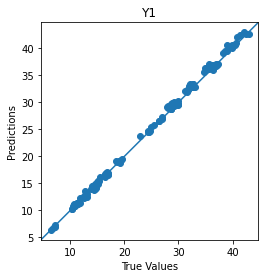

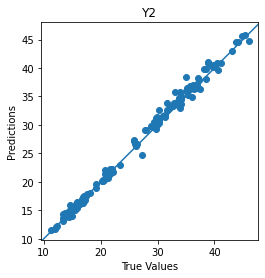

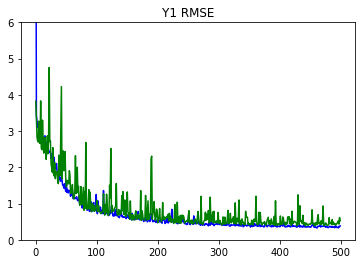

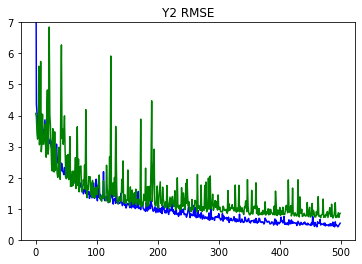

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)